<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
from indicators import *
from dataset import Dataset
from forecaster import Forecaster
from solver import Solver
from os.path import join, isfile
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
%matplotlib inline

# torch.manual_seed(seed=42)

/Users/achar/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/achar/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


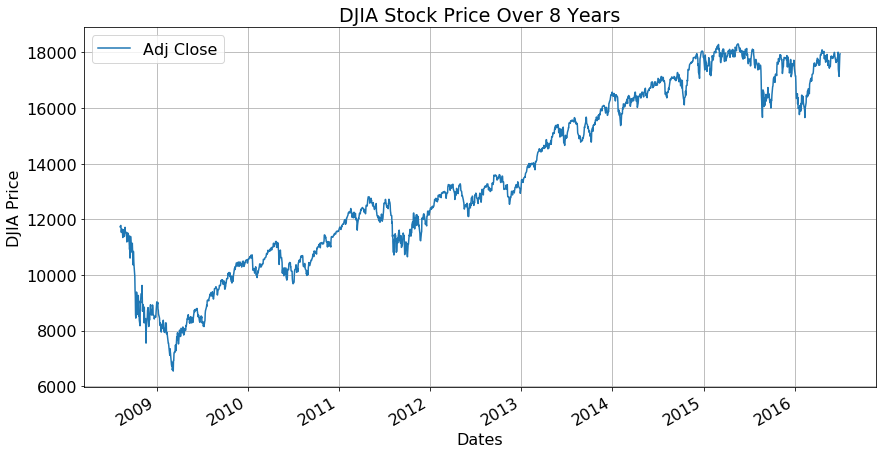

In [19]:
# Open the data file
data_path = 'data/'
filename = 'djia.csv'
full_path = join(data_path, filename)
assert (isfile(full_path))

# Reads in data and checks to see none of the data is null
df_prices = pd.read_csv(full_path)
assert (df_prices.isnull().sum().sum() == 0)

# Processes file so that data is indexed by date
df_prices = df_prices.sort_values(by='Date')
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.set_index('Date', inplace=True)

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(11, 5))
ax = fig.add_axes([0, 0, 1, 1])
df_prices.plot(y='Adj Close', ax=ax)
ax.set_xlabel('Dates')
ax.set_ylabel('DJIA Price')
ax.set_title('DJIA Stock Price Over 8 Years')
fig.autofmt_xdate(rotation=30)
ax.grid()
plt.show()

In [20]:
####################
# Pre Process Headlines
####################

# Open the data file
data_path = 'data/'
filename = 'djia_headlines.csv'
full_path = join(data_path, filename)
assert (isfile(full_path))

# Reads in data and checks to see none of the data is null
df_news = pd.read_csv(full_path)

# Processes file so that data is indexed by date
df_news = df_news.sort_values(by='Date')
df_news['Date'] = pd.to_datetime(df_news['Date'])
df_news.set_index('Date', inplace=True)

# Cleanup
# Uppercase words help with VADER so do not do this
# df = df.apply(lambda x: x.astype(str).str.lower())
df_news = df_news.apply(lambda x: x.astype(str))

df_news.drop(['Label'], inplace=True, axis=1)
# Removes b and "
df_news = df_news.applymap(lambda x: x.lstrip('b" ').rstrip('"'))
# Removes '
df_news = df_news.applymap(lambda x: x.lstrip("b'").rstrip("'"))
to_replace = {
    '\\r\\n': ' ',
    '\\n': ' ',
    '\\r': ' ',
    '\\t': ' ',
    '\\s': ' ',
    "\\\\\\'": "'",
    "\\'": "'"
}

df_news = df_news.replace(to_replace, regex=True)
df_news.head(3)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,Georgia 'downs two Russian warplanes' as count...,BREAKING: Musharraf to be impeached.,Russia Today: Columns of troops roll into Sout...,Russian tanks are moving towards the capital o...,"Afghan children raped with 'impunity,' U.N. of...",150 Russian tanks have entered South Ossetia w...,"Breaking: Georgia invades South Ossetia, Russi...",The 'enemy combatent' trials are nothing but a...,Georgian troops retreat from S. Osettain capit...,Did the U.S. Prep Georgia for War with Russia?,...,Georgia Invades South Ossetia - if Russia gets...,Al-Qaeda Faces Islamist Backlash,"Condoleezza Rice: ""The US would not act to pre...",This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Ossetia,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,No Help for Mexico's Kidnapping Surge
2008-08-11,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict,Jewish Georgian minister: Thanks to Israeli tr...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks 'faked,What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in S.Ossetia blames...,Welcome To World War IV! Now In High Definition!,"Georgia's move, a mistake of monumental propor...",...,Israel and the US behind the Georgian aggression?,"""Do not believe TV, neither Russian nor Georgi...",Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer,War in South Ossetia [PICS],Israeli Physicians Group Condemns State Torture,Russia has just beaten the United States over...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war,So this is what it's come to: trading sex for ...
2008-08-12,Remember that adorable 9-year-old who sang at ...,Russia 'ends Georgia operation,"""If we had no sexual harassment we would have ...",Al-Qa'eda is losing support in Iraq because of...,Ceasefire in Georgia: Putin Outmaneuvers the West,Why Microsoft and Intel tried to kill the XO $...,Stratfor: The Russo-Georgian War and the Balan...,I'm Trying to Get a Sense of This Whole Georgi...,The US military was surprised by the timing an...,U.S. Beats War Drum as Iran Dumps the Dollar,...,U.S. troops still in Georgia (did you know the...,Why Russias response to Georgia was right,"Gorbachev accuses U.S. of making a ""serious bl...","Russia, Georgia, and NATO: Cold War Two",Remember that adorable 62-year-old who led you...,War in Georgia: The Israeli connection,All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America: The New Mexico?,BBC NEWS | Asia-Pacific | Extinction 'by man n...


In [33]:
batch_size = 14
seq_length = 10
predict_ahead = 2

USE_HEADLINES = False

technical_indicators = [
    sma,  # Simple Moving Average
    wma,  # Weighted Moving Average
    mom,  # Exponential Moving Average
    macd,  # Moving Average Convergence Divergence
    rsi,  # Relative Strength Indicator
    stoch,  # Stochastic %K and %D
    willr,  # Larry Williams %R
    adosc,  # Accumulation / Distribution Oscillator
#     arima_sma,  # ARIMA on a SMA
#     arima_wma,  # ARIMA on a WMA 
#     arima_ema,  # ARIMA on an EMA
]

prices = df_prices.filter(['High', 'Low', 'Volume', 'Adj Close'], axis=1)

names = {
    'High': 'high',
    'Low': 'low',
    'Volume': 'volume',
    'Adj Close': 'close'
}

prices.rename(columns=names, inplace=True)

# Load parameter file
with open('params/djia.yaml') as file:
    params = yaml.full_load(file)

# Prepare signals dictionary layout for uploading features
signals = resetSignals(technical_indicators, params)

if USE_HEADLINES:
    headlines = df_news.filter(
        ['Date', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5'], axis=1)
else:
    headlines = None

features, labels = cleanData(prices, signals, predict=predict_ahead,
                                headlines=headlines, name='djia',
                                verbose=False)        

# Prepare data for nn training
n_features = features.shape[1]

# Want to perform this on full data set before splitting
# otherwise some numbers might be larger in validation set
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler = scaler.fit(features)
scaled = scaler.transform(features)

x_all, y_all = create_sequences(scaled, labels, seq_length=seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    x_all,
    y_all,
    test_size=0.25,
    # random_state=seed)
    shuffle=False)

print('X Train Shape: ', X_train.shape)
print('X Test Shape: ', X_test.shape)
print('Y Train Shape: ', y_train.shape)
print('Y Test Shape: ', y_test.shape)

data_sets = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_test, y_test)
}

dataloaders = {
    'train': DataLoader(data_sets['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data_sets['val'], batch_size=1, shuffle=False)
}
dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}

baseline = np.ones_like(y_test)
accuracy = accuracy_score(y_test, baseline)
print(f'Average Baseline Accuracy: {round(accuracy, 4) * 100}%')

Removing 35 rows from data
X Train Shape:  (1458, 10, 10)
X Test Shape:  (487, 10, 10)
Y Train Shape:  (1458, 1)
Y Test Shape:  (487, 1)
Average Baseline Accuracy: 56.26%


In [34]:
# model = Forecaster(n_features=n_features, n_hidden=32, n_layers=2, dropout=0.5)
model = Forecaster(n_features=n_features, n_hidden=8, n_layers=1)
solver = Solver(model, num_epochs=10, verbose=True, plot=True)
model = solver.train(dataloaders, dataset_sizes)

Using cpu for training.


/Users/achar/miniconda3/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 1-train Loss: 0.6869 Acc: 0.5652
Epoch: 1-val Loss: 0.6853 Acc: 0.5626
Epoch: 2-train Loss: 0.6856 Acc: 0.5658
Epoch: 2-val Loss: 0.6855 Acc: 0.5626
Epoch: 3-train Loss: 0.6847 Acc: 0.5658
Epoch: 3-val Loss: 0.6853 Acc: 0.5626
Epoch: 4-train Loss: 0.6853 Acc: 0.5658
Epoch: 4-val Loss: 0.6853 Acc: 0.5626
Epoch: 5-train Loss: 0.6850 Acc: 0.5658
Epoch: 5-val Loss: 0.6853 Acc: 0.5626
Epoch: 6-train Loss: 0.6852 Acc: 0.5658
Epoch: 6-val Loss: 0.6853 Acc: 0.5626
Epoch: 7-train Loss: 0.6853 Acc: 0.5658
Epoch: 7-val Loss: 0.6854 Acc: 0.5626
Epoch: 8-train Loss: 0.6853 Acc: 0.5658
Epoch: 8-val Loss: 0.6853 Acc: 0.5626
Epoch: 9-train Loss: 0.6848 Acc: 0.5658
Epoch: 9-val Loss: 0.6853 Acc: 0.5626
Epoch: 10-train Loss: 0.6846 Acc: 0.5658
Epoch: 10-val Loss: 0.6853 Acc: 0.5626
Training complete in 0m 9s
Best val acc: 0.562628


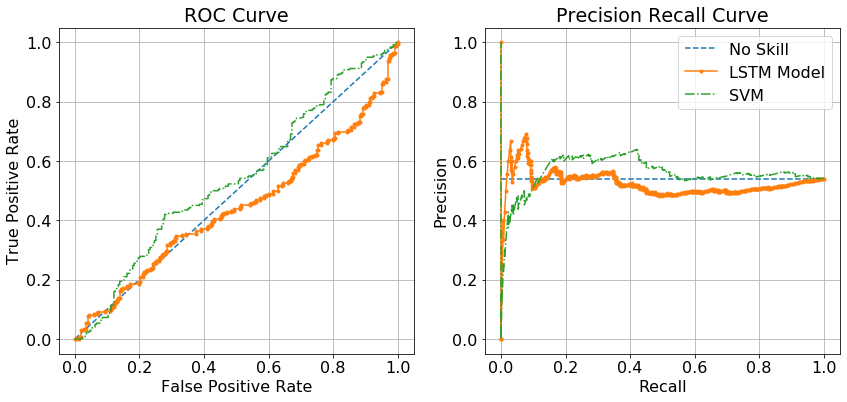

No Skill: ROC AUC=0.500
No Skill: Precision=0.540
No Skill: Recall=1.000
No Skill: Accuracy=0.540
-------------------------
LSTM Model: ROC AUC=0.444
LSTM Model: PR AUC=0.523
LSTM Model: Precision=0.540
LSTM Model: Recall=1.000
LSTM Model: Accuracy=0.540


In [27]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

COMPARE_W_SVM = True
if COMPARE_W_SVM:
    svm_pred = np.load('data/svm_prob_indicators_only.npy')[3:,0]
    assert y_test.flatten().shape[0] == svm_pred.shape[0]

# Model and no skill guess (always trending up)
y_test, y_pred = solver.eval(model, dataloaders['val'])
ns_pred = np.ones_like(y_pred)

fig = plt.figure(figsize=(14, 6))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_pred)
ml_fpr, ml_tpr, _ = roc_curve(y_test, y_pred)

plt.subplot(1, 2, 1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(ml_fpr, ml_tpr, marker='.', label='LSTM Model')

if COMPARE_W_SVM:
    svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_pred)
    plt.plot(svm_fpr, svm_tpr, linestyle='-.', label='SVM')
    
plt.grid()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ml_precision, ml_recall, _ = precision_recall_curve(y_test, y_pred)
no_skill = len(y_test[y_test == 1]) / len(y_test)

plt.subplot(1, 2, 2)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(ml_recall, ml_precision, marker='.', label='LSTM Model')

if COMPARE_W_SVM:
    svm_precision, svm_recall, _ = precision_recall_curve(y_test, svm_pred)
    plt.plot(svm_recall, svm_precision, linestyle='-.', label='SVM')

plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.savefig('imgs/ml_models_comparison.png')
plt.show()

# Calculate scores
ns_roc_auc = roc_auc_score(y_test, ns_pred)
ml_roc_auc = roc_auc_score(y_test, y_pred)
ml_pr_auc = auc(ml_recall, ml_precision)

ml_classifications = classify(y_pred, threshold=0.5)
ns_classifications = classify(ns_pred, threshold=0.5)

ns_accuracy = accuracy_score(y_test, ns_classifications)
ns_precision = precision_score(y_test, ns_classifications)
ns_recall = recall_score(y_test, ns_classifications)

ml_accuracy = accuracy_score(y_test, ml_classifications)
ml_precision = precision_score(y_test, ml_classifications)
ml_recall = recall_score(y_test, ml_classifications)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_roc_auc))
print('No Skill: Precision=%.3f' % ns_precision)
print('No Skill: Recall=%.3f' % ns_recall)
print('No Skill: Accuracy=%.3f' % ns_accuracy)
print('-------------------------')
print('LSTM Model: ROC AUC=%.3f' % (ml_roc_auc))
print('LSTM Model: PR AUC=%.3f' % (ml_pr_auc))
print('LSTM Model: Precision=%.3f' % ml_precision)
print('LSTM Model: Recall=%.3f' % ml_recall)
print('LSTM Model: Accuracy=%.3f' % ml_accuracy)

In [28]:
modelparams = {}
modelparams['n_features'] = features.shape[1]
modelparams['n_hidden'] = 32
modelparams['n_layers'] = 2
modelparams['dropout'] = 0.7

solverparams = {}
solverparams['num_epochs'] = 10
solverparams['verbose'] = False
solverparams['plot'] = False

results = calcMetrics(modelparams, solverparams, dataloaders,
                      dataset_sizes, iters=5, threshold=0.5)
accuracy, precision, recall = results

print('LSTM Model: Accuracy=%.3f' % accuracy)
print('LSTM Model: Precision=%.3f' % precision)
print('LSTM Model: Recall=%.3f' % recall)

Model Evaluation #1


KeyboardInterrupt: 

How does the number of days you choose to predict ahead affect the model prediction?

In [31]:
batch_size = 14
seq_length = 10
look_ahead = np.arange(1, 31)

accuracy = np.empty_like(look_ahead, dtype=np.float)
precision = np.empty_like(look_ahead, dtype=np.float)
recall = np.empty_like(look_ahead, dtype=np.float)

for i, predict in enumerate(look_ahead):
    print(f'Evaluating model - predict ahead: {predict}')
    
    # Prepare signals dictionary layout for uploading features
    signals = resetSignals(technical_indicators, params)
    headlines = None

    features, labels = cleanData(prices, signals, predict=predict,
                                 headlines=headlines, name='djia',
                                 verbose=False)    

    # Prepare data for nn training
    n_features = features.shape[1]

    # Want to perform this on full data set before splitting
    # otherwise some numbers might be larger in validation set
    scaler = MinMaxScaler(feature_range=(0.05, 0.95))
    scaler = scaler.fit(features)
    scaled = scaler.transform(features)

    x_all, y_all = create_sequences(scaled, labels, seq_length=seq_length)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(x_all, y_all,
                                                        test_size=0.25,
                                                        shuffle=False)
    data_sets = {
        'train': Dataset(X_train, y_train),
        'val': Dataset(X_test, y_test)
    }
    dataloaders = {
        'train': DataLoader(data_sets['train'], batch_size=batch_size, shuffle=True),
        'val': DataLoader(data_sets['val'], batch_size=1, shuffle=False)
    }
    dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}

    model = Forecaster(n_features=modelparams['n_features'],
                       n_hidden=modelparams['n_hidden'],
                       n_layers=modelparams['n_layers'], 
                       dropout=modelparams['dropout'])

    solver = Solver(model, 
                    num_epochs=solverparams['num_epochs'], 
                    verbose=solverparams['verbose'],
                    plot=solverparams['plot'])
    
    model = solver.train(dataloaders, dataset_sizes)
    y_test, y_pred = solver.eval(model, dataloaders['val'])
    
    ml_classifications = classify(y_pred, threshold=0.5)
    accuracy[i] = accuracy_score(y_test, ml_classifications)
    precision[i] = precision_score(y_test, ml_classifications)
    recall[i] = recall_score(y_test, ml_classifications)

Evaluating model - predict ahead: 1
Removing 34 rows from data
Evaluating model - predict ahead: 2
Removing 35 rows from data
Evaluating model - predict ahead: 3
Removing 36 rows from data
Evaluating model - predict ahead: 4
Removing 37 rows from data
Evaluating model - predict ahead: 5
Removing 38 rows from data
Evaluating model - predict ahead: 6
Removing 39 rows from data
Evaluating model - predict ahead: 7
Removing 40 rows from data
Evaluating model - predict ahead: 8
Removing 41 rows from data
Evaluating model - predict ahead: 9
Removing 42 rows from data
Evaluating model - predict ahead: 10
Removing 43 rows from data
Evaluating model - predict ahead: 11
Removing 44 rows from data
Evaluating model - predict ahead: 12
Removing 45 rows from data
Evaluating model - predict ahead: 13
Removing 46 rows from data
Evaluating model - predict ahead: 14
Removing 47 rows from data
Evaluating model - predict ahead: 15
Removing 48 rows from data
Evaluating model - predict ahead: 16
Removing 49 

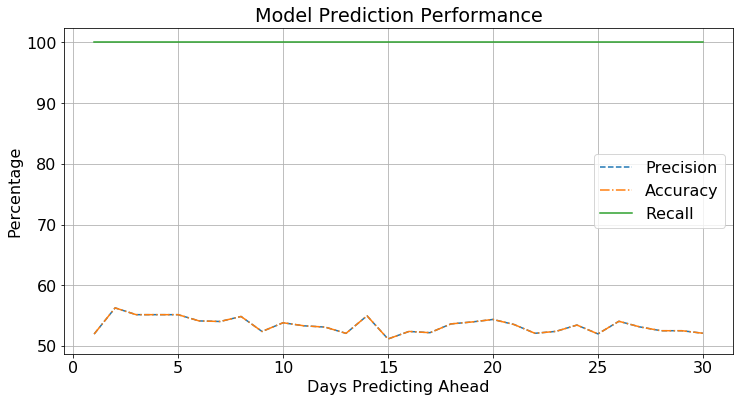

In [32]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 16
plt.plot(look_ahead, precision*100, linestyle='--', label='Precision')
plt.plot(look_ahead, accuracy*100, linestyle='-.', label='Accuracy')
plt.plot(look_ahead, recall*100, linestyle='-', label='Recall')
plt.xlabel('Days Predicting Ahead')
plt.ylabel('Percentage')
plt.title('Model Prediction Performance')
plt.legend()
plt.grid()
plt.savefig('imgs/model_performance_vs_days_ahead.png')
plt.show()

Comparison of ROC and PR Curves

Sentiment Analysis Plot

In [ ]:
import matplotlib

labels = ['Positive (score > 0.25)', 
          'Neutral (|score| <= 0.25)', 
          'Negative (score < -0.25)']
colors = ['yellowgreen', 'gold', 'lightcoral']

sentiment_class = np.empty_like(features[:,-5:])
sentiment_class[features[:,-5:] > 0.25] = 1
sentiment_class[np.logical_and(
    features[:,-5:] <= 0.25, features[:,-5:] >= -0.25)] = 0
sentiment_class[features[:,-5:] <= -0.25] = -1 

sizes = []
sizes.append(np.count_nonzero(sentiment_class == 1) / sentiment_class.size)
sizes.append(np.count_nonzero(sentiment_class == 0) / sentiment_class.size)
sizes.append(np.count_nonzero(sentiment_class == -1) / sentiment_class.size)
plt.figure(figsize=(14,5))
patches, plt.pie(sizes, colors=colors, shadow=True, startangle=90, autopct='%1.1f%%')
plt.legend(patches, labels, loc='center right', borderaxespad=0.2)
plt.title('Sentiment Score Summary of Reddit Headlines')
plt.axis('equal')
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.savefig('imgs/djia_sentiment_of_headlines.png', dpi=300)
plt.show()